In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
df = pd.read_excel('data/employment/GSS.xls',index_col=1)

In [3]:
from code.organize import *

In [4]:
variables = extract_variables('data/employment/GSS.sps')

In [5]:
replace_variables(df,variables)

In [29]:
df.head()

,year,wrkstat,hrs2,marital,sex,babies,preteen,teens,adults,happy
Respondent id number,,,,,,,,,,
1,1994,Keeping house,Not applicable,Divorced,Female,2,3,0,1,Pretty happy
3,1994,Working fulltime,Not applicable,Married,Female,0,0,0,2,Pretty happy
6,1994,Working parttime,Not applicable,Never married,Female,0,0,0,3,Pretty happy
7,1994,Working fulltime,Not applicable,Widowed,Female,0,1,1,2,Not too happy
9,1994,Working fulltime,Not applicable,Widowed,Female,2,1,0,2,Pretty happy


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30213 entries, 1 to Data collection: General Social Survey
Case Selection: (Combined.year >= 1994 AND Combined.year <= 2014)
Data columns (total 10 columns):
year       30212 non-null object
wrkstat    30211 non-null object
hrs2       30211 non-null object
marital    30211 non-null object
sex        30211 non-null object
babies     30211 non-null object
preteen    30211 non-null object
teens      30211 non-null object
adults     30211 non-null object
happy      30211 non-null object
dtypes: object(10)
memory usage: 2.5+ MB


In [29]:
from code.roughEDA import *

In [56]:
df.sex = df.sex.astype('string')

In [84]:
df[df['sex']=='Female']['wrkstat'].value_counts()

Working fulltime    7284
Keeping house       3047
Retired             2439
Working parttime    2134
School               568
Unempl, laid off     491
Other                418
Temp not working     386
No answer              7
Name: wrkstat, dtype: int64

In [133]:
pd.crosstab(df.ye,df.sex)

sex,Female,Male
wrkstat,,
Keeping house,3047,255
No answer,7,7
Other,418,365
Retired,2439,2213
School,568,393
Temp not working,386,226
"Unempl, laid off",491,578
Working fulltime,7284,8322
Working parttime,2134,1078


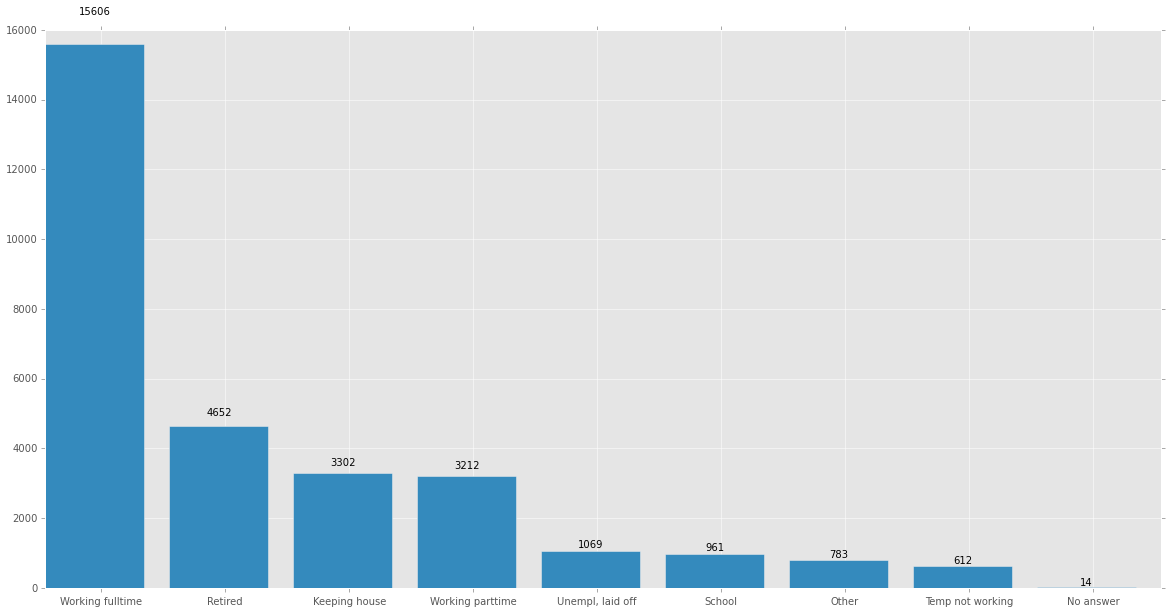

In [33]:
simple_bar(df.wrkstat, size = (20,10))